# Multi-Layer Perceptron Classifier using TensorFlow and Keras

In this notebook we build a Multi-Layer Perceptron (MLP) classifier by using TensorFlow and Keras.

MLP is a feed-forward Artificial Neural Network (ANN). A MLP is composed of a single input layer, one or more hidden layers, and a single output layer. MLPs are trained by using the backpropagation algorithm.


### The Backpropagation Algorithm
The backpropagation algorithm takes two passes through the network (one forward, one backward) to compute the gradient of the network’s error with regard to every single model parameter. In other words, it can find out how each connection weight and each bias term should be tweaked in order to reduce the error. Once it has these gradients, it just performs a regular Gradient Descent step, and the whole process is repeated until the network converges to the solution.

The TensorFlow provides an API to perform automatic differentiation by using a technique called **reverse-mode autodiff**. It is fast (requires just two passes) and precise, and is well suited when the function to differentiate has many variables (e.g., connection weights) and few outputs (e.g., one loss). It requires significantly less space (as compared to e.g., the method of finite difference approximation) for the computation which is extremely useful for large ANNs: https://www.tensorflow.org/guide/autodiff


### Implementation using TensorFlow & Keras 

Keras is a high-level Deep Learning API that allows to easily build, train, evaluate, and execute all sorts of ANNs. 

TensorFlow 2 has adopted Keras as its official high-level API: tf.keras. It only supports TensorFlow as the backend, but it has the advantage of offering some very useful extra features: for example, it supports TensorFlow’s Data API, which makes it easy to load and preprocess data efficiently.


### Dataset

We use the MNIST (Modified National Institute of Standards and Technology) dataset for classification. It is a set small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

There are 70,000 images. Each image is grayscale 28 x 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Thus, each image has 784 features.

In [1]:
import warnings
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras

## Load Dataset: Train & Test Subset

We load the MNIST data using Kears' utility function that allows to fetch and load common datasets.

Note few things about the Keras loading function.

- Every image is represented as a 28 × 28 pixel matrix (rather than a 1D array of size 784). 

- The pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0).

In [2]:
mnist = keras.datasets.mnist

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()


print("\nNo. of Full Training Samples: ", X_train_full.shape)
print("No. of Full Training Labels: ", y_train_full.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nType of the training/test samples: ", X_train_full.dtype)
print("Type of the training/test labels: ", y_train_full.dtype)


No. of Full Training Samples:  (60000, 28, 28)
No. of Full Training Labels:  (60000,)

No. of Testing Samples:  (10000, 28, 28)
No. of Testing Labels:  (10000,)

Type of the training/test samples:  uint8
Type of the training/test labels:  uint8


## View Sample Images from the Dataset with their Labels

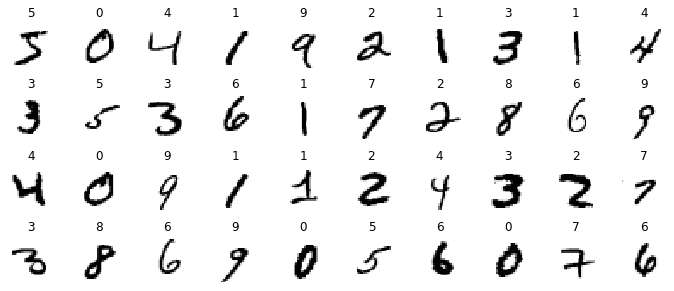

In [3]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train_full[index], fontsize=12)

        plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Input Image Format: Grayscale 

The images are in grayscale format.

A grayscale (or graylevel) image is simply one in which the only colors are shades of gray. The reason for differentiating such images from any other sort of color image is that less information needs to be provided for each pixel.

In fact a 'gray' color is one in which the red, green and blue components all have equal intensity in RGB space, and so it is only necessary to specify a single intensity value for each pixel, as opposed to the three intensities needed to specify each pixel in a full color image.

For a grayscale image, the pixel value is a single number that represents the brightness of the pixel. The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of possible values from 0 to 255.

Typically 0 is taken to be black, and 255 is taken to be white. Values in between make up the different shades of gray.


## Display a Random Image

We display a random grayscale image by using Matplotlib’s imshow() function.

We see that there are white numbers on a black background, each thickly written just in the middle and they are quite low resolution (28 x 28 pixels).

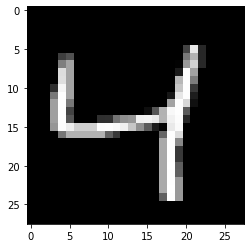

In [4]:
random_digit_image = X_train_full[2]

plt.imshow(random_digit_image, cmap = 'gray', interpolation="nearest")
#plt.axis("off")
plt.show()

## Display an Image as a Matrix Its of Pixel Values

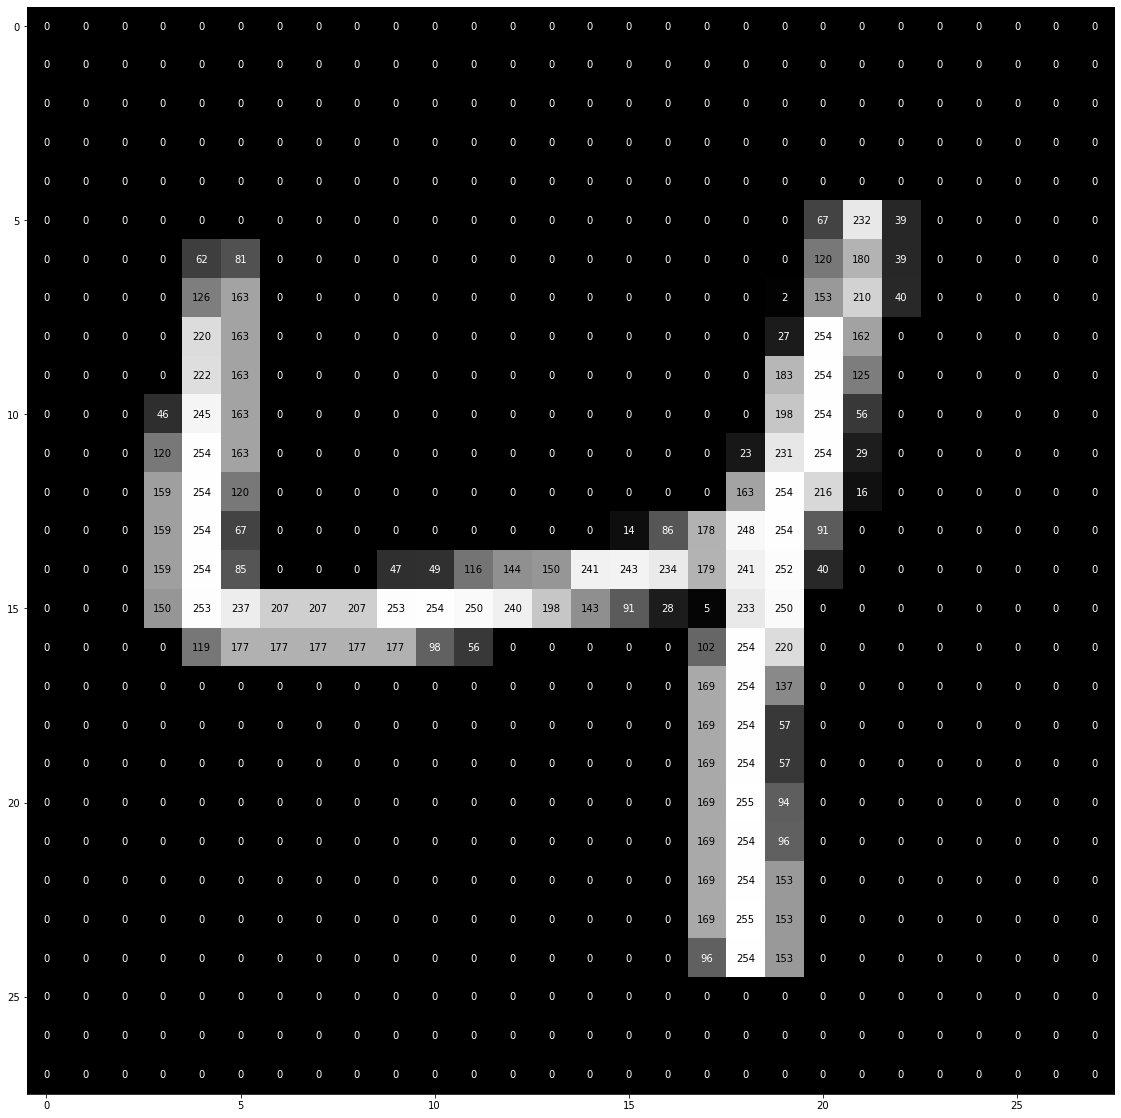

In [5]:
# Visualize a number with its pixel values
def visualize_input(img):
    fig = plt.figure(figsize = (20,20)) 
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            plt.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

visualize_input(X_train_full[2])

## Create Validation Subset & Normalize The Data Via Data Saling

To avoid big weights that deal with the pixel values from between [0, 255], we scale the features matrices down.

A commonly used range is [0, 1].

In [6]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("\nNo. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)


No. of Training Samples:  (55000, 28, 28)
No. of Training Labels:  (55000,)

No. of Validation Samples:  (5000, 28, 28)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 28, 28)
No. of Testing Labels:  (10000,)

X type:  float64
y type:  uint8


## Create The Model


Creating an ANN model consists of two steps.
- Choose a suitable Keras model class & create the model using it
- Add layers of different types based on the need


#### Step 1: Choose a Suitable Model Class

There are three ways to create an ANN model using Keras: https://keras.io/api/models/

- The Sequential model: It's a straightforward and simple list of layers. It is limited to **single-input, single-output** stacks of layers.

- The Functional API: It's easy-to-use, fully-featured API that supports **arbitrary model architectures**. It is used for most use cases, and known as the Keras "industry strength" model.

- Model subclassing: It's used to implement **everything from scratch**. It's useful for complex, out-of-the-box research use cases.



For the **MNIST multi-class classification** problem we use the Sequential API. Because this problem requires a single-input and single-output model. The Sequential API creates a simple model composed of a single stack of layers connected sequentially.



#### Step 2: Add Suitable Layers

Layers are the basic building blocks of neural networks in Keras: https://keras.io/api/layers/ 

A layer consists of a tensor-in tensor-out computation function (the layer's call method) and some state, held in TensorFlow variables (the layer's weights).


For building a MLP ANN, we only need to add **core layers**, such as the Dense Layer: https://keras.io/api/layers/core_layers/


In other more sophisticated ANN architectures such as in Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs) we use Convolutional layers, Pooling layers, Recurrent layers, etc. Keras provides individual classes for each of these layer types.

In addition to this, for complex tasks we need to use Preprocessing layers, Normalization layers, Regularization layers.

Keras also provides classes of Layer weight initializers, Layer weight regularizers and Layer weight constraints.


For building a **MLP classifier**, we use the following Core layer
- Dense layer (a type of Core layer): https://keras.io/api/layers/core_layers/dense/

It's a regular densely-connected ANN layer.

Dense layer implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

The tf.keras.layers.Dense class has the following parameters:

- units: Number of output neurons.

- activation (default: **"linear" activation**): Activation function to use.

- use_bias (default: **True**): Boolean, whether the layer uses a bias vector.

- kernel_initializer (default: **"glorot_uniform"**): Initializer for the kernel weights matrix.

- bias_initializer (default: **"zeros"**): Initializer for the bias vector.

- kernel_regularizer (default: None): Regularizer function applied to the kernel weights matrix.

- bias_regularizer (default: None): Regularizer function applied to the bias vector.

- activity_regularizer (default: None): Regularizer function applied to the output of the layer (its "activation").

- kernel_constraint (default: None): Constraint function applied to the kernel weights matrix.

- bias_constraint (default: None): Constraint function applied to the bias vector.




#### There are 4 layers in our model: input preprocessing layer, 2 hidden layers and one output layer.

- Layer 1 (Input Preprocessing): At first, we need to flatten the input images to create 1D array for each image. It is done by the **Flatten layer** that reshapes the input data X as follows: X.reshape(-1, 1). It is a type of Reshaping layer: https://keras.io/api/layers/reshaping_layers/ 

        -- This layer does some simple preprocessing & does not have any parameters. Since it is the first layer in the model, we should specify the input_shape, which doesn’t include the batch size, only the shape of the instances, i.e., 28 x 28. 
        
        An alternative to this is to flatten the input fetures prior creating the model. Then, in the model, instead of having the Flatten layer, we could simply add an Input layer that instantiates an input tensor for buildng the model as follows: keras.Input(shape=(784,)). Note that the shape value is 784 (don't include the batch size), not 28 x 28. Because we have had flattened the input already. 

- Layer 2 and 3 (Hidden Layers): Next we add two **Dense** hidden layers with 300 neurons ans 100 neurons, respectively. 

        -- A Dense layer is a regular densely-connected ANN layer. 

        -- We use the ReLU activation function. There are other activation functions of choice:
https://keras.io/api/layers/activations/

        -- Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). 


- Layer 4 (Output Layer): Finally, we add a **Dense** output layer with 10 neurons (one per class). We use the softmax activation function (because the classes are exclusive).

In [7]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- First Layer (InputPreprocessing): Flatten layer converts each input image into a 1D array
- Hidden Layers: Dense hidden layer with the ReLU activation function
- Output Layer: Dense output layer with 10 neurons.
                Since it's a multi-class classification, we use "softmax"  
                activation function in the output layer. 
'''


# Approach 1 (did not use): add the layers one by one
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[28, 28]))
# model.add(keras.layers.Dense(300, activation="relu"))
# model.add(keras.layers.Dense(100, activation="relu"))
# model.add(keras.layers.Dense(10, activation="softmax"))



# Approach 2: pass a list of layers when creating the Sequential model:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

## Model Summary

We display all the model’s layers by using the model’s summary() method. 

The summary includes the following:
- Each layer’s name (which is automatically generated unless we set it when creating the layer)
- Output shape (None means the batch size can be anything)
- The number of parameters
- At the end, the total number of parameters, including trainable and non-trainable parameters. 


We see that Dense layers have a lot of parameters. 

- The first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters. 

- The second hidden layer has 300 × 100 connection weights, plus 100 bias terms, which adds up to 30,100 parameters. 


This large number of parameters gives the model **quite a lot of flexibility** to fit the training data. But it also means that the model runs the risk of **overfitting**, especially when we do not have a lot of training data. 

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## Save the Model on a File

We can convert the Keras model to dot format and save to a file.

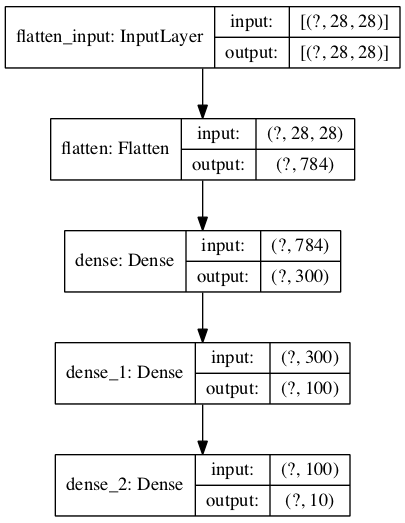

In [9]:
keras.utils.plot_model(model, to_file="mnist_model.png", show_shapes=True)

## Information about the Layers

Occassionally it is useful to get the weights of the layers. We can access all the parameters of a layer by using its get_weights() and set_weights() methods. 

For a Dense layer, this includes both the connection weights and the bias terms.


### Weight Initialization

The Dense layer initializes the connection weights **randomly** (which is needed to break symmetry). The default setting of the "kernel_initializer" parameter is "glorot_uniform": https://keras.io/api/layers/initializers/#glorotuniform-class

The biases are initialized to zeros, by deafult. 

It is important to initialize all the hidden layers’ connection weights randomly, or else training will fail. For example, if we initialize all weights and biases to zero, then all neurons in a given layer will be perfectly identical, and thus backpropagation will affect them in exactly the same way, so they will remain identical. If instead we randomly initialize the weights, we break the symmetry and allow backpropagation to train a diverse team of neurons.

See the following notebook for a comparative understanding of various weight (kernel) initialization techniques, including the Glorot initialization: https://github.com/rhasanbd/Artificial-Neural-Network-Back-to-Basics/blob/master/ANN-I-Initialization%20of%20the%20Weights.ipynb

We can use a different initialization method. For example, we can set kernel_initializer (i.e., the matrix of connection weights) or bias_initializer when creating the layer: https://keras.io/initializers/

Following example shows how to get information about the weights and biases of the first hidden layer. Observe that the weights are initialized randomly (and by zeros for the bias layer).

In [10]:
weights, biases = model.layers[1].get_weights()

print("First Hidden Layer Weights:\n", weights)

print("\nFirst Hidden Layer Weights Dimension:\n", weights.shape)

print("\nFirst Hidden Layer Bias:\n", biases)

print("\nFirst Hidden Layer Bias Dimension:\n",biases.shape)

First Hidden Layer Weights:
 [[ 0.02448617 -0.00877795 -0.02189048 ... -0.02766046  0.03859074
  -0.06889391]
 [ 0.00476504 -0.03105379 -0.0586676  ...  0.00602964 -0.02763776
  -0.04165364]
 [-0.06189284 -0.06901957  0.07102345 ... -0.04238207  0.07121518
  -0.07331658]
 ...
 [-0.03048757  0.02155137 -0.05400612 ... -0.00113463  0.00228987
   0.05581069]
 [ 0.07061854 -0.06960931  0.07038955 ... -0.00384101  0.00034875
   0.02878492]
 [-0.06022581  0.01577859 -0.02585464 ... -0.00527829  0.00272203
  -0.06793761]]

First Hidden Layer Weights Dimension:
 (784, 300)

First Hidden Layer Bias:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Compile the Model


We compile the model by specifying the loss function, optimizer & relevant metrics discussed below.


### Loss Function

Keras provides various types of loss functions: https://keras.io/api/losses/

Since we are prforming multiclass classification, we use the "sparse_categorical_crossentropy" loss function.

We use this loss function because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. 

If instead we had one target probability per class for each instance (such as one-hot vectors, e.g., [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. 

If we were doing binary classification (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.


### Optimizer

We train the model using simple **Stochastic Gradient Descent (SGD)** with mini-batches. Keras provides the SGD class that implements the Stochastic Gradient Descent optimizer with a learning rate and momentum. For the SGD optimizer it is imprtant to tune the learning rate and momentum: https://keras.io/api/optimizers/sgd/

There are other more efficient optimizers: https://keras.io/api/optimizers/

#### See the following two notebooks for a deep understanding of setting learning rate optimally for SGD:
- Optimal constant learning rate & momentum: https://github.com/rhasanbd/Smooth-Taste-of-Keras--Journey-Through-MLPs/blob/master/Keras-MLP%20Classifier-2-Hyperparameter%20Tuning.ipynb
- Comparative discussion on optimal constant learning rate, learning schedule & adaptive learning rate algorithms: https://github.com/rhasanbd/Smooth-Taste-of-Keras--Journey-Through-MLPs/blob/master/Keras-MLP%20Classifier-3-Learning%20Rate%20Experiments.ipynb


### Metrics

A metric is a function that is used to judge the performance of a model.

Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model.

Since we created a classifier, it’s useful to measure its "accuracy" during training and evaluation.

For a full list of the available metrics see: https://keras.io/api/metrics/

In [11]:
'''
Define the optimizer.
We use the best performing values for the learning rate and momentum from previous experiment.
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


'''
Compile the model.
Since we are using two different types of loss functions, we specify those using a list.
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

## Dynamic Visualization of Learning Curves

We may visualize the learning curves during training. TensorBoard provides a great interactive visualization tool to do this.

There are 5 steps.

- Step 1: First, we define the root log directory to use for our TensorBoard logs. All log files would be stored there.

- Step 2: Then, we define a small function to generate a subdirectory path based on the current date and time so that it’s different at every run. 

- Step 3: Finally, we create a TensorBoard "callback" object to enable visualizations for TensorBoard.

        This callback logs events for TensorBoard, including:
        - Metrics summary plots
        - Training graph visualization
        - Activation histograms
        - Sampled profiling

        For more information see: https://keras.io/api/callbacks/tensorboard/

- Step 4: During the model training (via the fit() method) we pass this callback object as a parameter. It will create the log directory, create event files and write summaries to them. 

- Step 5: To create dynamic learning curves, we load the tensor board server and view the learning curves (using data from the log directory) via a web browser.

In [12]:
'''
Step 1: First, we define the root log directory to use for our TensorBoard logs. 
All log files would be stored there.
'''
root_logdir = os.path.join(os.curdir, "my_logs")

'''
Step 2: Then, we define a small function to generate a subdirectory path based on 
the current date and time so that it’s different at every run.
'''

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() 
print(run_logdir)

'''
Step 3: Finally, we create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

./my_logs/run_2020_05_31-19_28_01


## Train the Model

We train the model by calling the fit() method: https://keras.io/api/models/model_training_apis/#fit-method

Following parameters are used.
- The input features (X_train) and the target classes (y_train) 
- The number of epochs to train
- A validation set (optional) 
- The TensorBoard callback object to write the events on the log

        The optional "batch_size" parameter uses a default batch size of 32.


At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, and the loss and accuracy on both the training set and the validation set. 

    To stop displaying these information set the "verbose" parameter to 0.

Note: Instead of passing a validation set using the validation_data argument, we could set validation_split to the ratio of the training set that we want Keras to use for validation. For example, validation_split=0.1 tells Keras to use the last 10% of the data (before shuffling) for validation.


### History Object

The fit() method returns a History object that contains:

- The training parameters (history.params)
- The list of epochs it went through (history.epoch)
- A dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any). 



### Saving and Restoring a Model

We can save a trained model using its save() method. However, it works only for the Sequential API and the Functional API.

Keras uses the Hierarchical Data Format version 5 (HDF5) format to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer (e.g., connection weights and biases). It also saves the optimizer (including its hyperparameters and any state it may have). 


### Saving Checkpoints

Often times training lasts several hours when training on large datasets. In this case, we should not only save our model at the end of training, but also save checkpoints at regular intervals during training, to avoid losing everything if our computer crashes. We can use callbacks for this purpose.

The fit() method accepts a callbacks argument that lets us specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch. 

We use the **ModelCheckpoint callback** to save checkpoints of our model at regular intervals during training, by default at the end of each epoch.

Since we are using a validation set during training, we set the "save_best_only" ModelCheckpoint parameter to "True". It will only save our model when its performance on the validation set is the best so far.


### Implementing Early Stopping

We can implement early stopping by using the **EarlyStopping callback**. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model. 

Following are the parameters of this callback:
- monitor: Quantity to be monitored.
- min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
- patience: Number of epochs with no improvement after which training will be stopped.
- verbose: verbosity mode.
- mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
- baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
- restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.


#### We combine the following three callbacks in the fit() method:

- Callback to enable visualizations for TensorBoard.
- Callback to save checkpoints of our model (in case computer crashes).
- Callback to interrupt training early when there is no more progress (to avoid wasting time and resources).


There are other callbacks that could be useful: https://keras.io/api/callbacks/

In [13]:
%%time

checkpoint_cb = keras.callbacks.ModelCheckpoint("MNIST_Model.h5",
                                                save_best_only=True)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


history = model.fit(X_train, y_train, 
                    batch_size=32, # batch size 32 is default
                    epochs=100,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])


model.save("MNIST_Model.h5")

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 78us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692
Epoch 2/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.1068 - accuracy: 0.9677 - val_loss: 0.0842 - val_accuracy: 0.9774
Epoch 3/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0775 - val_accuracy: 0.9770
Epoch 4/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0729 - val_accuracy: 0.9786
Epoch 5/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0680 - val_accuracy: 0.9808
Epoch 6/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.0744 - val_accuracy: 0.9814
Epoch 7/100
55000/55000 [==========================

## Display Learning Curves Dynamically via Web Browser

To see the learning curves dynamically via the web browser, first we need to start the tensor board server. Then, we execute the fit() method; and from the web browser we access the learning curves.

- Open a terminal a type the following command:

        tensorboard --logdir=./my_logs --port=6006

- Once the server is up, open a web browser and go to http://localhost:6006

Once the TensorBoard web interface is opened, click the SCALARS tab to view the learning curves. 

At the bottom left, we select the logs that we want to visualize (e.g., the training logs from the first and second run), and click the epoch_loss scalar. 


## Display Static Learning Curves after the Training is Completed

We can display the static learning curves at the end of the training. For this we use the dictionary obtained from the History object. It creates a pandas DataFrame and call the plot() method to get the learning curves.

{'batch_size': 32, 'epochs': 100, 'steps': 1719, 'samples': 55000, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}


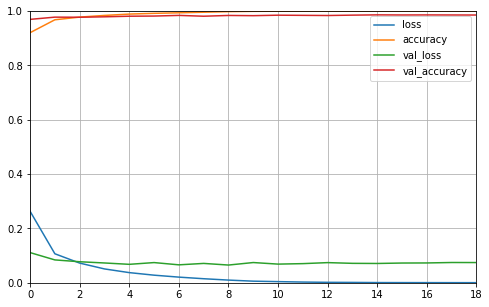

In [14]:
print(history.params)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Model Evaluation

There are at least three ways to evaluate the model.
- Use the evaluate() method to get validation loss and accuracy
- Use the predict() method to get test output, then compute accuracy, confusion matrix, etc.
- Use the predict_classes() method to get test output, then compute accuracy, confusion matrix, etc.


### The evaluate() Method

We can evaluate the model on the test set to estimate the generalization error (loss & accuracy) by using the evaluate() method. See the hyperparameters used by this method: https://keras.io/api/models/model_training_apis/#evaluate-method

This technique is not useful if we want to get confusion matrix.


### The predict() Method

We can also use the model’s predict() method to make predictions on new instances. It estimates one probability per class, from class 0 to class 9. Thus, it returns 10 probabilities for each instance. For the full dataset with N instances it returns a matrix of dimension N x 10. Then, we may use np.argmax() function with axis=1 to get the class label with the highest probability.


    
### The predict_classes() Method

Alternatively, we can use the model's predict_classes() method that returns the index (class label) with largest probability. For the full dataset with N instances it returns 1 1D array of size N.


        Below we show the code for both the predict() and predict_classes() methods. In practice, only one method should be used.
        
        
### Load the Saved Model

We can load the saved model using the load_model() method to make predictions.

In [15]:
# Load the saved model for making predictions
model = keras.models.load_model("MNIST_Model.h5")


print("Generalization Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class

# model.predict_classes(X_test) method returns the index (class label) with largest probability (1D array)
#y_test_predicted= model.predict_classes(X_test)


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)


test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Generalization Loss & Accuracy:  [0.06106927128024836, 0.9832]

Train Accuracy:  0.9992727272727273

Test Accuracy:  0.9832

Test Confusion Matrix:
[[ 972    0    0    1    2    0    2    1    2    0]
 [   0 1127    4    0    0    1    2    0    1    0]
 [   2    2 1013    3    2    0    2    5    2    1]
 [   0    0    5  993    0    3    0    1    3    5]
 [   1    0    0    0  970    0    5    3    0    3]
 [   2    0    0    9    1  872    5    0    3    0]
 [   3    3    1    1    3    2  945    0    0    0]
 [   1    5    4    2    0    0    0 1009    3    4]
 [   5    0    2    4    1    4    4    2  950    2]
 [   2    3    0    5    9    2    0    4    3  981]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98   